In [7]:
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib
import skimage.io as io
import seaborn as sns; sns.set_context("notebook")
font = {'size'   : 16, 'weight' : 'normal', 'family' : 'arial'}
matplotlib.rc('font', **font)

# Experimental information

*  xkappa biotin spots: these spots are coated with human kappa light chain conjugated to biotin, so that when the streptavidin-HRP is added there is strong signal independent of the serum content.  **We should not expect the fiducial signal to weaken with serial dilution.**
*  anti-His tag spots: All of the recombinant proteins that are used to coat the plates have hexa-His tags cloned into them, and the coat protein in these spots is anti-His. In this experiment, all of the recombinant antigens were spotted here on the anti-His coated spot, then serum was added so that the spot is representative of a polyclonal response. There was more cross-reactivity than expected and **this control will not be used in the future covid plates.**

# Data format conventions

For ease of reading and manipulating data, all data is converted in $n$-dimensional arrays. 
* Well metadata is #wells $\times$ 4 array. 
* antigen metadata is  #rows $\times$ #columns in the array.
* background corrected ODs is a 4D float array (Well row x Well column x Array row x Array column).

# TODO

####  All methods/transformations should use simple data structures, e.g., use numpy array as input and generate numpy array as output.

* defs: 
    * read_data: parse csv and xls to return array of well information, antigen information, and antigenODs.
    * plot_OD(antigen, sera, dilutions), antigen can be fiducial, positive control, negative control, or diagnostic. 
    * compareODs(antigens,sera), plots to compare ODs (antibody amount) across sera
    * estimateTiter(antigen, serum) dilution at which antigen becomes undetectable in given serum
 

# Read identity of wells and antigen spots

In [8]:
data_folder=r'/Volumes/GoogleDrive/My Drive/ELISAarrayReader/images_scienion/2020-03-30-15-08-05-COVD_March25_fluplatetest_AdamsPlate'
plateinfo_path=os.path.join(data_folder,'PlateInfoFLuplate.csv')
antigenOD_path=os.path.join(data_folder,'interpolationODs.xlsx') #change this for flu plate when available

In [9]:
plate_info_df=pd.read_csv(plateinfo_path)
plate_info_df.rename(columns={'Well': 'well_id', 'Type':'type', 'Dilution':'dilution'}, inplace=True)
serum_day_df=plate_info_df['Sera ID'].str.split('-Day', expand=True)
serum_day_df.fillna(0, inplace=True)
serum_day_df.columns=['serum', 'day']
plate_info_df = pd.concat([plate_info_df, serum_day_df], axis=1)
plate_info_df.drop(['Sera ID'], axis=1, inplace=True)
plate_info_df
plate_info_df['serum'].unique()

array(['HumanReferencePlasma', 'anti-HA mAb MEDI8852',
       'antii-HA mAb TF19', 'MS', '005-18', '006', 'AssayDiluentControl',
       'ab115777 RabbitTubulinControl'], dtype=object)

In [10]:
converter = {col: str for col in range(0,7)}
antigen_df = pd.read_excel(antigenOD_path, sheet_name='antigens', converters=converter, index_col=0)
antigen_df = antigen_df.unstack().reset_index(name='antigen') # unpivot (linearize) the table
antigen_df.rename(columns={'level_0': 'antigen_row', 'level_1': 'antigen_col'}, inplace=True)
antigen_df

,antigen_row,antigen_col,antigen
0,0,0,xkappa biotin
1,0,1,xkappa biotin
2,0,2,xIgG Fc
3,0,3,xIgG Fc
4,0,4,xIgG Fc
5,0,5,xkappa biotin
6,1,0,Flu vaccine 2018-2019
7,1,1,H1 HA
8,1,2,H3 HA
9,1,3,H7 HA


# Read ODs of all wells

## Read data

In [11]:
row_label=['A','B','C','D','E','F','G','H']
col_label=[str(idx) for idx in np.arange(12)+1]
antigenOD=np.empty((8,12,6,6)) # 96 wells, 6 antigen rows, 8 antigen columns
wellID=np.empty((8,12),dtype=object)

In [12]:
# Read all wells into dictionary and into a 4D numpy array.
OD_df = pd.DataFrame()
for r in np.arange(8):
    for c in np.arange(12):
        well_key = row_label[r]+col_label[c]
        OD_1_well_df = pd.read_excel(antigenOD_path, sheet_name=well_key, index_col=0)
        OD_1_well_df = OD_1_well_df.unstack().reset_index(name='OD') # unpivot (linearize) the table
        OD_1_well_df.rename(columns={'level_0': 'antigen_row', 'level_1': 'antigen_col'}, inplace=True)
        OD_1_well_df['well_id'] = well_key
        wellID[r,c] = well_key
        OD_df = OD_df.append(OD_1_well_df, ignore_index=True)
OD_df

,antigen_row,antigen_col,OD,well_id
0,0,0,1.365038,A1
1,0,1,1.300022,A1
2,0,2,1.527346,A1
3,0,3,1.383002,A1
4,0,4,1.235165,A1
...,...,...,...,...
3451,5,1,0.998054,H12
3452,5,2,1.019230,H12
3453,5,3,1.020443,H12
3454,5,4,1.021060,H12


# Merge tables into one

In [13]:
OD_df = pd.merge(OD_df,
                 antigen_df,
                 how='left', on=['antigen_row', 'antigen_col'])
OD_df = pd.merge(OD_df,
                 plate_info_df,
                 how='left', on=['well_id'])

OD_df

,antigen_row,antigen_col,OD,well_id,antigen,type,dilution,serum,day
0,0,0,1.365038,A1,xkappa biotin,Control,1.0,HumanReferencePlasma,0
1,0,1,1.300022,A1,xkappa biotin,Control,1.0,HumanReferencePlasma,0
2,0,2,1.527346,A1,xIgG Fc,Control,1.0,HumanReferencePlasma,0
3,0,3,1.383002,A1,xIgG Fc,Control,1.0,HumanReferencePlasma,0
4,0,4,1.235165,A1,xIgG Fc,Control,1.0,HumanReferencePlasma,0
...,...,...,...,...,...,...,...,...,...
3451,5,1,0.998054,H12,empty,Control,1.0,AssayDiluentControl,0
3452,5,2,1.019230,H12,GFP foldon,Control,1.0,AssayDiluentControl,0
3453,5,3,1.020443,H12,GFP foldon,Control,1.0,AssayDiluentControl,0
3454,5,4,1.021060,H12,GFP foldon,Control,1.0,AssayDiluentControl,0


# Plot standard curves

## Plot one serum

[None]

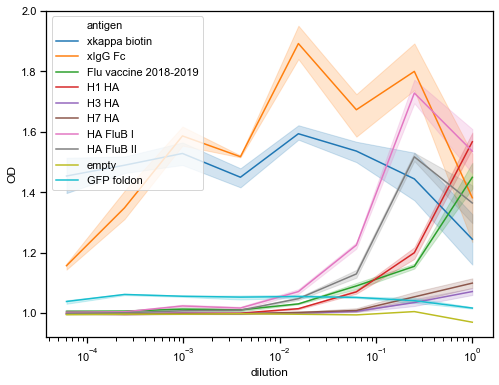

In [15]:
serum = 'HumanReferencePlasma'
sub_df = OD_df[(OD_df['serum']==serum)] 
# ref_plm_df = ref_plm_df.dropna()
plt.figure(figsize =(8, 6))
ax = sns.lineplot(x="dilution", y="OD", hue='antigen', data=sub_df)
ax.set(xscale="log")

## Compare across serums at Day 0

<Figure size 576x432 with 0 Axes>

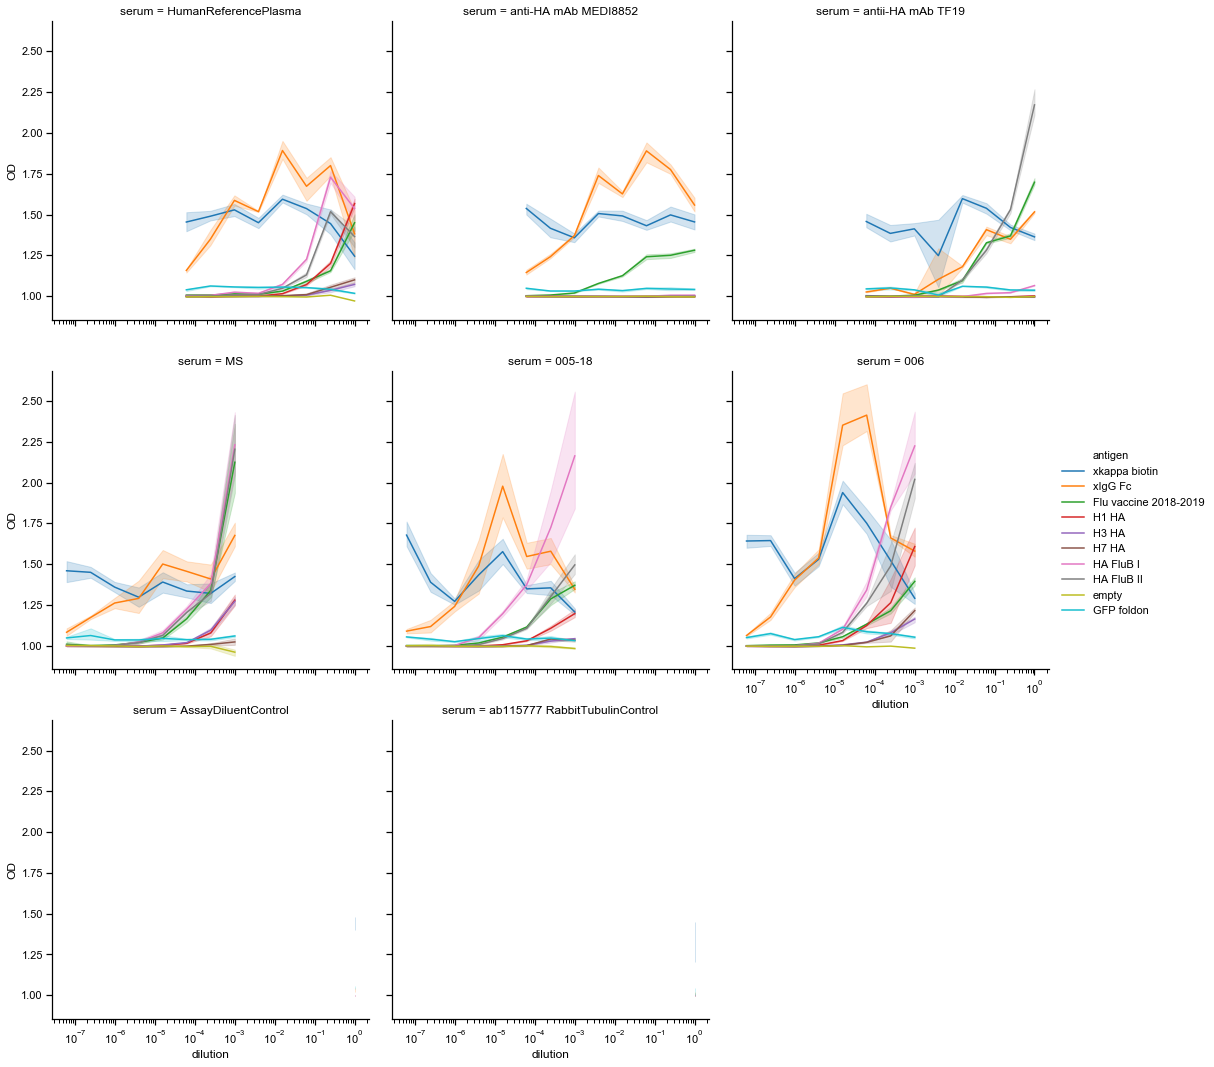

In [17]:
day = 0
ref_plm_df = OD_df[(OD_df['day']==0)] 
plt.figure(figsize =(8, 6))
ax = sns.relplot(x="dilution", y="OD",
                hue="antigen", col="serum",
                kind="line", data=OD_df, col_wrap=3)
ax.set(xscale="log")

## Compare sera for each antigen

<Figure size 432x432 with 0 Axes>

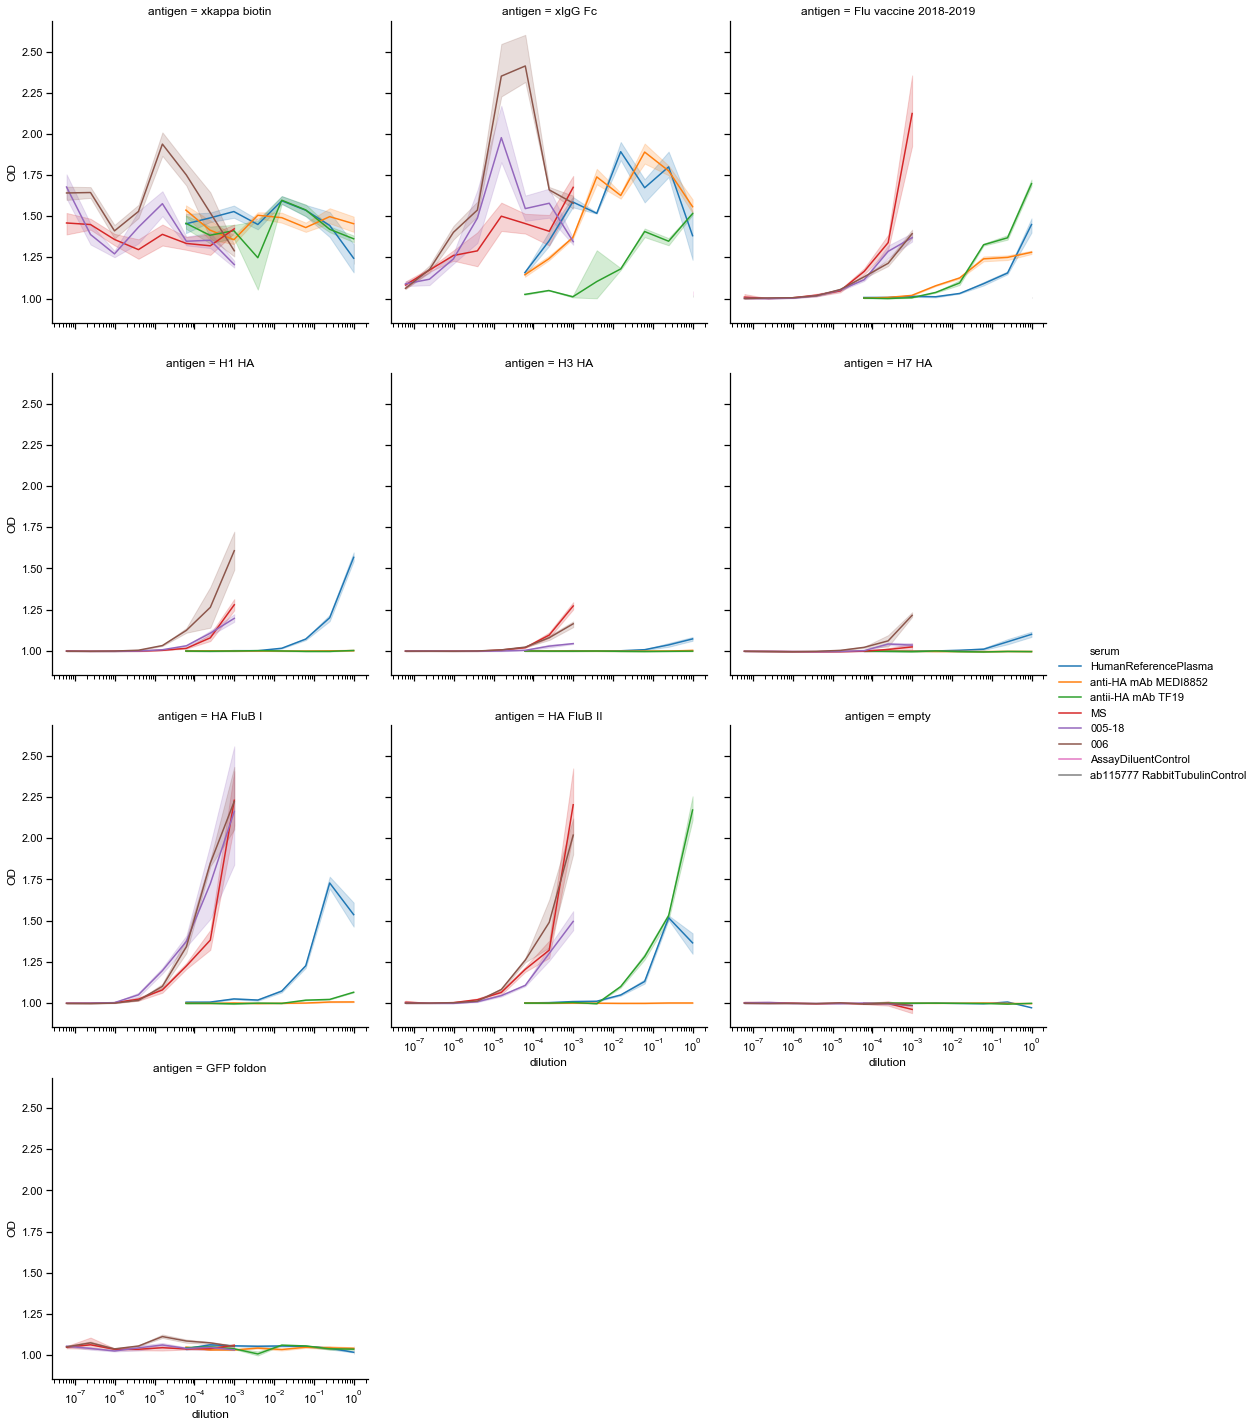

In [18]:
ref_plm_df = OD_df
plt.figure(figsize =(6, 6))
ax = sns.relplot(x="dilution", y="OD",
                hue="serum", col="antigen",
                kind="line", data=OD_df, col_wrap=3)
ax.set(xscale="log")

## Check dilutions of the missing plots

In [19]:
serum = 'AssayDiluentControl'
sub_df = OD_df[(OD_df['serum']==serum)]
print(sub_df['dilution'].unique())

serum = 'ab115777 RabbitTubulinControl'
sub_df = OD_df[(OD_df['serum']==serum)]
print(sub_df['dilution'].unique())

[1.]
[1.]


## Find concentrations in control wells

#The control wells in this plate are in columns, not rows, so this is reflected below. A2-H2 is an anti-HA antibody against spots in the top spot row, A3-H3 is an anti-HA antibody against spots in the top spot row and bottom spot row. Column 12 of the plate contains an assay diluent control.

In [53]:
controlWells = []
for row in ['A','B','C','D','E','F','G','H']:
    wellsinthisrow = [row+str(col) for col in range(2,4)]
    controlWells.append(wellsinthisrow)
pprint(controlWells)

[['A2', 'A3'],
 ['B2', 'B3'],
 ['C2', 'C3'],
 ['D2', 'D3'],
 ['E2', 'E3'],
 ['F2', 'F3'],
 ['G2', 'G3'],
 ['H2', 'H3']]


In [54]:
controlWells = np.reshape(controlWells,(1,16))

In [60]:
wellmetaIdx.shape

(4,)

In [65]:
controlWells.shape

(16,)

In [63]:
controlWells = np.reshape(controlWells,(16,))

In [62]:
wellIdx.shape

(96,)

In [64]:
controlConcentrations=np.concatenate([plateInfo[wellIdx == well, wellmetaIdx == 'Concentration'] for well in controlWells])
pprint(controlConcentrations)

array([1.0, 1.0, 0.25, 0.25, 0.0625, 0.0625, 0.015625, 0.015625,
       0.00390625, 0.00390625, 0.000976563, 0.000976563,
       0.00024414099999999997, 0.00024414099999999997, 6.10352e-05,
       6.10352e-05], dtype=object)


In [77]:
#Commenting this out in favor of the above cell for this plate
#controlWells=np.array(['H'+str(col) for col in range(2,10)])
#controlConcentrations= np.concatenate([plateInfo[wellIdx == well,wellmetaIdx == 'Concentration'] for well in controlWells])
#pprint(controlConcentrations)

In [66]:
for well in controlWells:
    print(well)

A2
A3
B2
B3
C2
C3
D2
D3
E2
E3
F2
F3
G2
G3
H2
H3


In [67]:

concentrationsAll = np.array([float(strconc) for strconc in controlConcentrations])
pprint(concentrationsAll)

array([1.00000e+00, 1.00000e+00, 2.50000e-01, 2.50000e-01, 6.25000e-02,
       6.25000e-02, 1.56250e-02, 1.56250e-02, 3.90625e-03, 3.90625e-03,
       9.76563e-04, 9.76563e-04, 2.44141e-04, 2.44141e-04, 6.10352e-05,
       6.10352e-05])


In [68]:
concentrations=concentrationsAll[1::2]
pprint(concentrations)

array([1.00000e+00, 2.50000e-01, 6.25000e-02, 1.56250e-02, 3.90625e-03,
       9.76563e-04, 2.44141e-04, 6.10352e-05])


In [74]:
controlWellsMEDI=controlWells[0::2]
pprint(controlWellsMEDI)

array(['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'H2'], dtype='<U2')


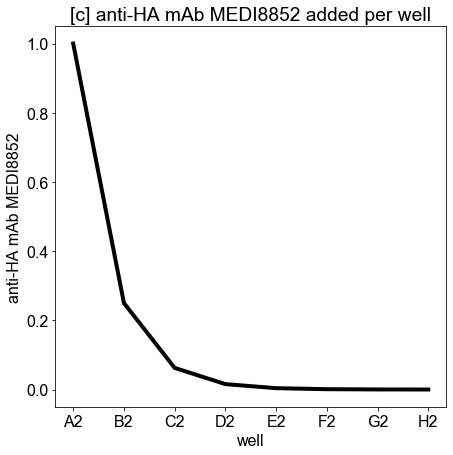

In [69]:
plt.figure(figsize=(7,7))
plt.plot(concentrations, lw=4, c='k')
plt.xticks(ticks=np.arange(len(concentrations)),labels=controlWells[0::2])
plt.xlabel('well')
plt.ylabel('anti-HA mAb MEDI8852')
plt.title('[c] anti-HA mAb MEDI8852 added per well');
#The plot for anti-HA mAb TF19 will look the same as this one, same concentrations per well but A3

## Let's look at spot 16061 which shows some dynamic range over H1..H9.

In [75]:
antigenvaccine=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'Flu vaccine 2018-2019'] for well in controlWellsMEDI])
pprint(antigenvaccine)

array([[1.29361701, 1.28230958, 1.26620668, 1.28148715],
       [1.22413749, 1.25108522, 1.26219094, 1.26221479],
       [1.23226354, 1.21985598, 1.24805682, 1.26364718],
       [1.1328589 , 1.12572158, 1.11748446, 1.12382501],
       [1.07654113, 1.07959817, 1.08066351, 1.07320915],
       [1.01554702, 1.02020619, 1.01955793, 1.01968565],
       [1.00726404, 1.00590698, 1.00645212, 1.00599513],
       [1.00224073, 1.00265987, 1.00239297, 1.00151115]])


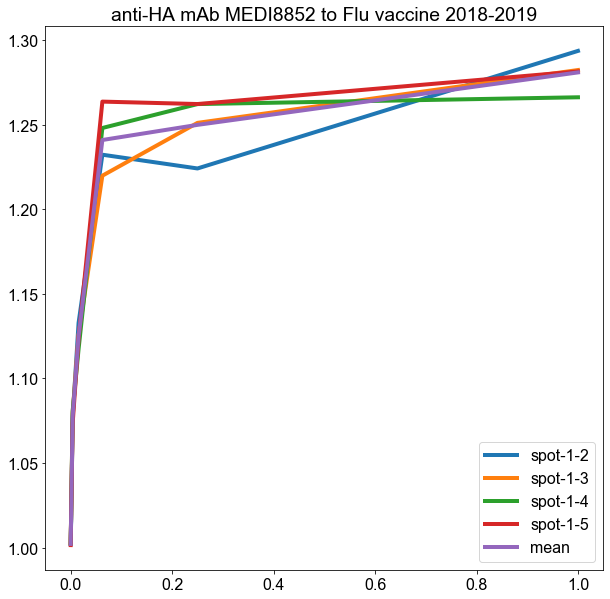

In [77]:
antigenvaccine=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'Flu vaccine 2018-2019'] for well in controlWellsMEDI])

plt.figure(figsize=(10,10))
plt.plot(concentrations,antigenvaccine,concentrations,np.mean(antigenvaccine,axis=1),lw=4 );
plt.legend(['spot-1-2','spot-1-3','spot-1-4','spot-1-5','mean'])
plt.title('anti-HA mAb MEDI8852 to Flu vaccine 2018-2019');


## Fit a 4PL to mean values from anti-HA mAB MEDI8852 to vaccine spots

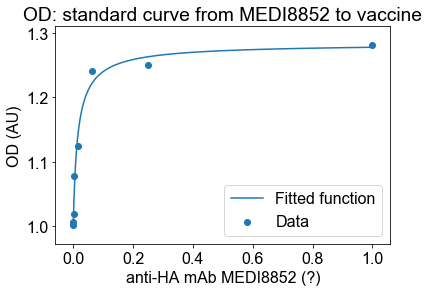

In [88]:
import scipy.optimize as optimization
xdata = concentrations
ydata = np.mean(antigenvaccine,axis=1)
def fourPL(x, A, B, C, D):
    return ((A-D)/(1.0+((x/C)**(B))) + D)

guess = [0, -0.5, 0.5, 1]
params, params_covariance = optimization.curve_fit(fourPL, xdata, ydata, guess)#, maxfev=1)

x_min, x_max = np.amin(xdata), np.amax(xdata)
xs = np.linspace(x_min, x_max, 1000)
plt.scatter(xdata, ydata, label='Data')
plt.plot(xs, fourPL(xs, *params), label='Fitted function')
plt.legend(loc='best')
plt.xlabel('anti-HA mAb MEDI8852 (?)')
plt.ylabel('OD (AU)')
plt.title('OD: standard curve from MEDI8852 to vaccine');
plt.show()

## Compare OD curves for antigen 114 for mouse 2 vs mouse 6.

There are 2 biological replicates for each mouse: mouse 2 is columns 3 and 4, and mouse 6 is columns 11 and 12.
There are two technical replicates (spots) for antigen 114 in each well. 
Serial dilutions are across row-A to row-G, starting with 1:50 dilution in row-A.

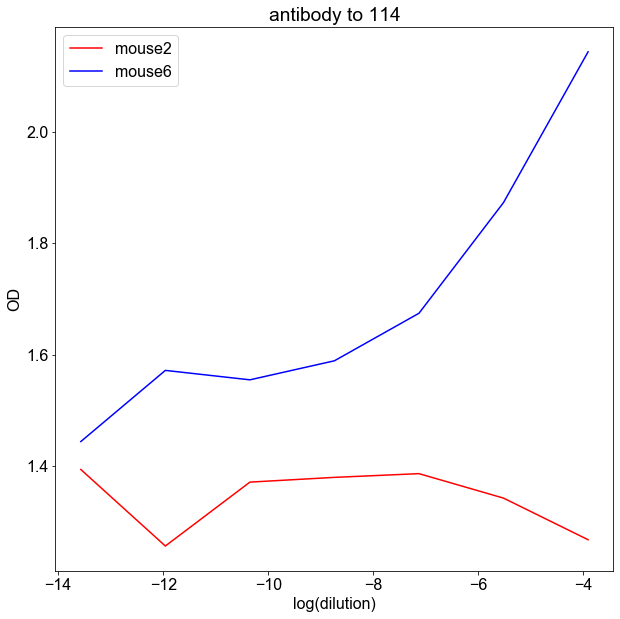

In [35]:
mouse2_rep1=['A3','B3','C3','D3','E3','F3','G3']
mouse2_rep2=['A4','B4','C4','D4','E4','F4','G4']
mouse6_rep1=['A11','B11','C11','D11','E11','F11','G11']
mouse6_rep2=['A12','B12','C12','D12','E12','F12','G12']

dilutions=[(1/50)/5**d for d in range(0,7)]

antigen114mouse2rep1=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == '114'] for well in mouse2_rep1])
antigen114mouse2rep1=np.mean(antigen114mouse2rep1,axis=1) # average within each well.
antigen114mouse2rep2=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == '114'] for well in mouse2_rep2])
antigen114mouse2rep2=np.mean(antigen114mouse2rep2,axis=1) # average within each well.
antigen114mouse2=0.5*(antigen114mouse2rep1+antigen114mouse2rep2) # average across wells.

antigen114mouse6rep1=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == '114'] for well in mouse6_rep1])
antigen114mouse6rep1=np.mean(antigen114mouse6rep1,axis=1) # average within each well.
antigen114mouse6rep2=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == '114'] for well in mouse6_rep2])
antigen114mouse6rep2=np.mean(antigen114mouse6rep2,axis=1) # average within each well.
antigen114mouse6=0.5*(antigen114mouse6rep1+antigen114mouse6rep2) # average across wells.

plt.figure(figsize=(10,10))
plt.plot(np.log(dilutions),antigen114mouse2,'r', np.log(dilutions),antigen114mouse6,'b')
plt.xlabel('log(dilution)') 
plt.ylabel('OD')
plt.title('antibody to 114')
plt.legend(['mouse2', 'mouse6'])
# antigen114mouse2=np.mean(antigen114mouse2,axis=1)
# antigen114mouse2Replicate=0.5*(antigen114mouse2[0::2]+antigen114mouse2[1::2])
# plt.plot(np.log(dilutions),np.log(antigen114mouse2Replicate))